In [1]:
# Load required libraries
import numpy as np
import pandas as pd

# Custom utils from kesh-utils (Check source code: https://github.com/KeshavShetty/kesh-utils)
from KUtils.common import utils
from KUtils.eda import chartil
from KUtils.eda import data_preparation as dp
from KUtils.classifier import generic_classifier_utils as gcu

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer, recall_score, precision_score


In [2]:
# Show all column in head()
pd.set_option('display.max_columns', None)

In [3]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [4]:
# Data generated from ../Sampleing.ipyb
train_df = pd.read_csv('wns_train_df.csv')

test_df = pd.read_csv('wns_test_df.csv')


In [5]:
print(train_df.shape)
   
print(test_df.shape)


(237609, 17)
(90675, 16)


In [6]:
train_df.head()

,impression_id,user_id,app_code,is_4G,is_click,items_count,sessions_count,item_price_mean,app_summary,intermediate,latest,old,app_count,device_type,user_id_check,item_price_server_time_hour_min_max,item_price_server_time_hour_std_score
0,c4ca4238a0b923820dcc509a6f75849b,87862,422,0,0,1,1,2350.000000,0.082192,0,0,1,3,1,0,0.001749,-0.335557
1,45c48cce2e2d7fbdea1afc51c7c6ad26,63410,467,1,1,12,1,4452.833333,0.085714,0,1,0,52,1,1,0.000760,-0.389445
2,70efdf2ec9b086079795c442636b55fb,71748,259,1,0,2,1,1598.500000,0.067164,1,0,0,9,1,1,0.001655,-0.340678
3,8e296a067a37563370ded05f5a3bf3ec,69209,244,1,0,18,1,9963.388889,0.034424,0,1,0,4,1,0,0.013555,0.307723
4,182be0c5cdcd5072bb1864cdee4d3d6e,62873,473,0,0,45,1,8796.400000,0.000000,0,1,0,16,1,0,0.002101,-0.316376


In [7]:
test_df.head()

,impression_id,user_id,app_code,is_4G,items_count,sessions_count,item_price_mean,app_summary,intermediate,latest,old,app_count,device_type,user_id_check,item_price_server_time_hour_min_max,item_price_server_time_hour_std_score
0,a9e7126a585a69a32bc7414e9d0c0ada,44754,127,1,1,1,23424.000000,0.046154,0,1,0,NaN,1,0,0.017467,0.520876
1,caac14a5bf2ba283db7708bb34855760,29656,44,0,70,1,11010.428571,NaN,0,1,0,6.0,1,1,0.000212,-0.419315
2,13f10ba306a19ce7bec2f3cae507b698,25234,296,1,8,1,5331.875000,0.070988,0,1,0,NaN,1,0,0.001574,-0.345067
3,39c4b4dc0e9701b55a0a4f072008fb3f,22988,207,1,35,1,14800.628571,0.047619,0,1,0,7.0,1,1,0.003088,-0.262610
4,bf5a572cca75f5fc67f4b14e58b11d70,35431,242,1,28,1,8778.285714,NaN,0,1,0,20.0,1,1,0.008576,0.036455


# 1. Model 1 on inner (With Bayesian Optimization)

In [8]:
train_df = train_df
# Putting feature variable to X
X = train_df.drop(['impression_id', 'is_click'],axis=1)

# Putting response variable to y
y = train_df['is_click']

X_train = X
y_train = y

X_test = X
y_test = y

In [9]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)

from bayes_opt import BayesianOptimization

def bo_tune_xgb(max_depth, gamma, n_estimators ,learning_rate, subsample, colsample_bytree):
    params = {'max_depth': int(max_depth),
        'gamma': gamma,
        'n_estimators': int(n_estimators),
        'learning_rate':learning_rate,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'tree_method': 'gpu_hist',
        'eval_metric': 'rmse'}
    #Cross validating with the specified parameters in 5 folds and 70 iterations
    cv_result = xgb.cv(params, dtrain, num_boost_round=70, nfold=5)
    #Return the negative RMSE
    return -1.0*cv_result['test-rmse-mean'].iloc[-1]

xgb_bo = BayesianOptimization(bo_tune_xgb, {
    'max_depth': (5,13),
    'gamma': (0, 1),
    'learning_rate':(0, 1),
    'n_estimators':(300, 500),
    'subsample': (0,1),
    'colsample_bytree': (0,1)                                            
})
xgb_bo.maximize(n_iter=5, init_points=8)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------


/home/kooud/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/kooud/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


|  1        | -0.2058   |  0.5514   |  0.853    |  0.1845   |  8.749    |  331.6    |  0.5845   |
|  2        | -0.2312   |  0.8809   |  0.3054   |  0.509    |  12.53    |  464.2    |  0.4018   |
|  3        | -0.2061   |  0.6028   |  0.4577   |  0.3632   |  6.638    |  432.3    |  0.7621   |
|  4        | -0.2317   |  0.6046   |  0.279    |  0.4932   |  12.83    |  387.1    |  0.3645   |
|  5        | -0.2099   |  0.23     |  0.3613   |  0.7579   |  9.942    |  346.8    |  0.8626   |
|  6        | -0.2062   |  0.6311   |  0.1336   |  0.0978   |  11.71    |  495.8    |  0.3972   |
|  7        | -0.229    |  0.674    |  0.65     |  0.7058   |  9.469    |  413.7    |  0.3377   |
|  8        | -0.2134   |  0.6874   |  0.8662   |  0.9187   |  5.077    |  358.3    |  0.3186   |
|  9        | -0.2071   |  0.02726  |  0.09004  |  0.224    |  12.92    |  300.1    |  0.9737   |
|  10       | -0.2067   |  0.0      |  1.0      |  1.0      |  5.0      |  500.0    |  1.0      |
|  11       | -0.209

In [10]:
#Extracting the best parameters
params = xgb_bo.max['params']
print(params)

#Converting the max_depth and n_estimator values from float to int
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])
params['tree_method']= 'gpu_hist'
print(params)

#Initialize an XGBClassifier with the tuned parameters and fit the training data
from xgboost import XGBClassifier
final_clf = XGBClassifier(**params).fit(X_train, y_train)

#predicting for training set
y_pred_default = final_clf.predict(X_test)

{'colsample_bytree': 0.5513825541939047, 'gamma': 0.853044478989406, 'learning_rate': 0.18453834789380041, 'max_depth': 8.749130811171483, 'n_estimators': 331.60189077117843, 'subsample': 0.5844926438775926}
{'colsample_bytree': 0.5513825541939047, 'gamma': 0.853044478989406, 'learning_rate': 0.18453834789380041, 'max_depth': 8, 'n_estimators': 331, 'subsample': 0.5844926438775926, 'tree_method': 'gpu_hist'}


In [11]:
inner_model = final_clf

In [12]:
# Printing classification report
print(classification_report(y_test, y_pred_default))

local_confusion_matrix = metrics.confusion_matrix(y_test, y_pred_default )

# Printing confusion matrix and accuracy
print('Confusion Matrix:')
print(local_confusion_matrix)

# Accuracy, precision, recall and f1 score
print('\nScores:')
accuracy = metrics.accuracy_score(y_test, y_pred_default)
precision = metrics.precision_score(y_test, y_pred_default)
recall = metrics.recall_score(y_test, y_pred_default)
f1_score = metrics.f1_score(y_test, y_pred_default)
roc_auc = metrics.roc_auc_score(y_test, y_pred_default)
sensitivity = recall
specificity =  local_confusion_matrix[0,0]/(local_confusion_matrix[0,0]+local_confusion_matrix[0,1])
print(" Accuracy {0:.3f}, \n Sensitivity {1:.3f}, \n Specificity {2:.3f}, \n Precision {3:.3f}, \n Recall {4:.3f}, \n f1_score {5:.3f}, \n roc_auc {6:.3f}".format(
    accuracy, sensitivity,specificity, precision,recall,f1_score,roc_auc))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    226747
           1       0.81      0.07      0.12     10862

    accuracy                           0.96    237609
   macro avg       0.89      0.53      0.55    237609
weighted avg       0.95      0.96      0.94    237609

Confusion Matrix:
[[226581    166]
 [ 10135    727]]

Scores:
 Accuracy 0.957, 
 Sensitivity 0.067, 
 Specificity 0.999, 
 Precision 0.814, 
 Recall 0.067, 
 f1_score 0.124, 
 roc_auc 0.533


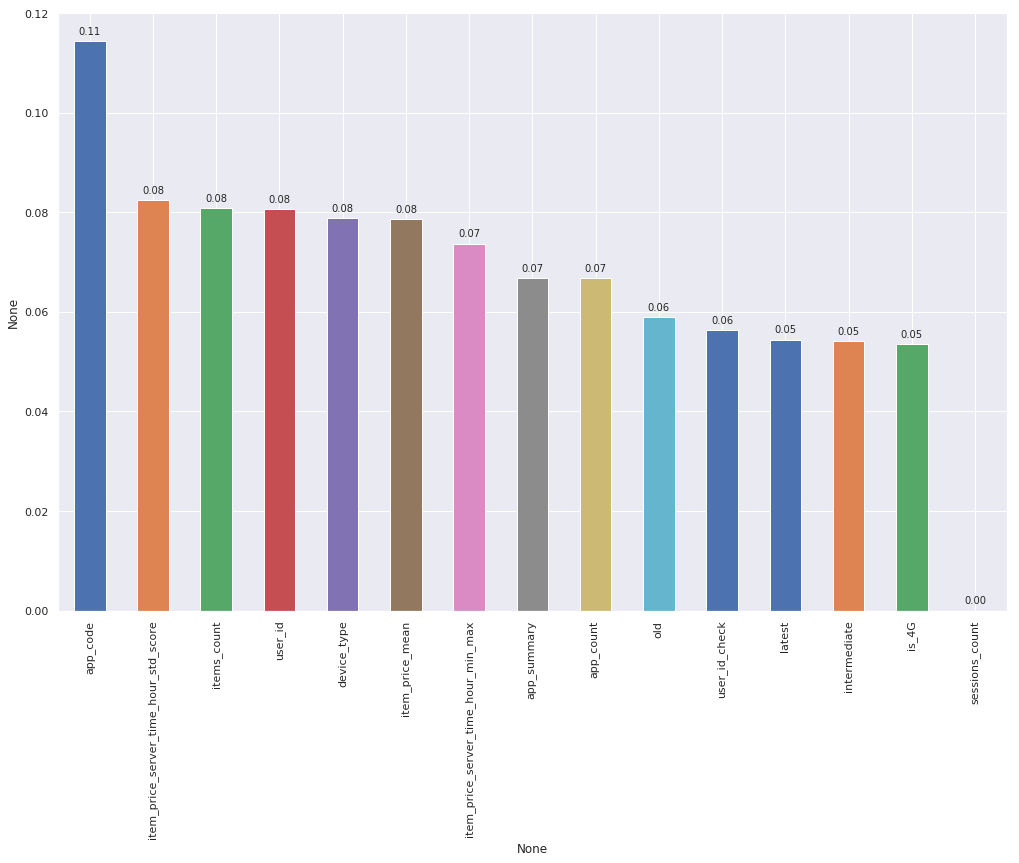

In [13]:
# Feature importance
importances = final_clf.feature_importances_
unique_dict = dict(zip(X_train.columns, importances))
chartil.core_barchart_from_series(
    pd.Series(unique_dict), 
    optional_settings={'sort_by_value':True, 'decimal_precision':2}) 

In [14]:
print(inner_model)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5513825541939047,
              gamma=0.853044478989406, learning_rate=0.18453834789380041,
              max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
              n_estimators=331, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.5844926438775926, tree_method='gpu_hist',
              verbosity=1)


# Apply final model on test 

In [15]:
test_df.columns

Index(['impression_id', 'user_id', 'app_code', 'is_4G', 'items_count',
       'sessions_count', 'item_price_mean', 'app_summary', 'intermediate',
       'latest', 'old', 'app_count', 'device_type', 'user_id_check',
       'item_price_server_time_hour_min_max',
       'item_price_server_time_hour_std_score'],
      dtype='object')

In [16]:
train_df.columns

Index(['impression_id', 'user_id', 'app_code', 'is_4G', 'is_click',
       'items_count', 'sessions_count', 'item_price_mean', 'app_summary',
       'intermediate', 'latest', 'old', 'app_count', 'device_type',
       'user_id_check', 'item_price_server_time_hour_min_max',
       'item_price_server_time_hour_std_score'],
      dtype='object')

In [17]:
test_df.shape

(90675, 16)

In [18]:
ext_pred_proba = inner_model.predict_proba(test_df.drop(['impression_id'], axis=1))

In [19]:
test_df['is_click'] = ext_pred_proba[:,1]


In [20]:
inner_tst = test_df.loc[:,['impression_id', 'is_click' ]]

In [21]:
inner_tst.head()

,impression_id,is_click
0,a9e7126a585a69a32bc7414e9d0c0ada,0.005825
1,caac14a5bf2ba283db7708bb34855760,0.002757
2,13f10ba306a19ce7bec2f3cae507b698,0.115533
3,39c4b4dc0e9701b55a0a4f072008fb3f,0.005755
4,bf5a572cca75f5fc67f4b14e58b11d70,0.153471


In [22]:
submission_csv = inner_tst

In [23]:
submission_csv.shape

(90675, 2)

In [24]:
submission_csv.to_csv("WNS_xgb_submission.csv", index=False)
